## PLN1 - Procesamiento del Lenguaje Natural I ##

Nombre: José Aviani

Código: a2103

### Desafío 2 ###

---

### Dataset: ###

#### 'Bob Dylan songs' de Kaggle ####

https://www.kaggle.com/datasets/cloudy17/bob-dylan-songs

Vamos a utilizar como corpus las letras de canciones de Bob Dylan, premio Novel de Literatura del año 2016.

---

Instalamos las librerías necesarias:

In [20]:
%pip install gdown
%pip install pandas
%pip install tensorflow
%pip install gensim
%pip install scikit-learn
%pip install plotly
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Hacemos los imports necesarios:

In [21]:
import os
import zipfile
import gdown
import shutil
import random
import pandas as pd
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [22]:
random.seed(84)

---

Descargamos el dataset:

In [23]:
data_dir = os.path.join(os.getcwd(), "data")

def descargar_dataset(data_dir):

  # Verificar si exsite la carpeta
  if not os.path.exists(data_dir):

    try:
      # Nombre del archivo ZIP que se va a guardar
      ZIP_NAME = "kaggle-Bob_Dylan_songs.zip"
      zip_path = os.path.join(data_dir, ZIP_NAME)

      # Crear carpeta data
      os.makedirs(data_dir, exist_ok=True)

      # Descargar el ZIP
      print("Descargando archivo zip ...")
      # Lo tomamos de Google Drive porque Kaggle requeire autenticación
      gdown.download(id="1Rjdxl8I3wtff1wCOuXSwdlx3aGa8vDkD", output=zip_path, quiet=False)
      print("Archivo zip descargado.")

      # Descomprimir el ZIP
      print("Descomprimiendo archivo ...")
      with zipfile.ZipFile(zip_path, "r") as zf:
          zf.extractall(data_dir)
      print("Archivo descomprimido.")
    except:
      # En caso de error, eliminar la carpeta creada
      shutil.rmtree(data_dir, ignore_errors=True)
      print("Ocurrió un error al descargar el dataset.")

  print(f"Dataset descargado en: '{data_dir}'")


# Descargar el dataset (solo si no existe la carpeta data)
descargar_dataset(data_dir)

Dataset descargado en: 'c:\Users\Jose\CEIA\Materias\PLN1\TPs\Desafio_2\data'


Cargamos el dataset:

In [24]:
# Armamos el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv(
    os.path.join(data_dir, "clear.csv"),
    sep='/n',
    header=None,
    names=['texto'],
    engine='python'
)
df.head()

,texto
0,"1961,""The Bootleg Series, Vol 1-3: Rare & Unre..."
1,"Sing it to you right, but you might think it’s..."
2,Just a little glimpse of a story I’ll tell
3,’Bout an East Coast city that you all know well
4,It’s hard times in the city


In [25]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 14063


---

No vamos a hacer comentarios ni aclaraciones adicionales a todo lo que fue simplememnte tomado de la notebook presentada en la clase (no tiene sentido).

### Punto 1: Crear vectores

#### Preprocesamiento: ####

Transformamos cada una de las oraciones en una secuencia de palabras y hacemos limpieza de esas palabras:

In [26]:
sentence_tokens = []
for _, row in df[:None].iterrows():
  sentence_tokens.append(text_to_word_sequence(row[0]))

C:\Users\Jose\AppData\Local\Temp\ipykernel_16200\357928099.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [27]:
sentence_tokens[10]

['it’s', 'hard', 'times', 'in', 'the', 'city']

In [28]:
sentence_tokens[:2]

[['1961',
  'the',
  'bootleg',
  'series',
  'vol',
  '1',
  '3',
  'rare',
  'unreleased',
  '1961',
  '1991',
  'hard',
  'times',
  'in',
  'new',
  'york',
  'town',
  'come',
  'you',
  'ladies',
  'and',
  'you',
  'gentlemen',
  'a',
  'listen',
  'to',
  'my',
  'song'],
 ['sing',
  'it',
  'to',
  'you',
  'right',
  'but',
  'you',
  'might',
  'think',
  'it’s',
  'wrong']]

#### Crear los vectores (word2vec) ####

In [29]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [30]:
w2v_model = Word2Vec(min_count=5,
                     window=2,
                     vector_size=300,
                     negative=20,
                     workers=1,
                     sg=1)

In [31]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [32]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 14063


In [33]:
# Cantidad de términos encontrados en el corpus
print("Cantidad de términos distintos en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de términos distintos en el corpus: 2091


#### Entrenar embeddings ####

Entrenamos el modelo para generar los vectores.

El número de epochs utilizado fue ajustado analizando los términos más y menos similares obtenidos en el punto 2.

In [34]:
epochs=50

w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=epochs,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 798216.375
Loss after epoch 1: 566491.375
Loss after epoch 2: 524394.0
Loss after epoch 3: 476163.0
Loss after epoch 4: 443637.75
Loss after epoch 5: 436025.5
Loss after epoch 6: 427314.25
Loss after epoch 7: 420382.75
Loss after epoch 8: 394615.5
Loss after epoch 9: 380481.0
Loss after epoch 10: 375997.0
Loss after epoch 11: 369693.5
Loss after epoch 12: 365529.0
Loss after epoch 13: 360996.0
Loss after epoch 14: 358189.5
Loss after epoch 15: 353144.5
Loss after epoch 16: 350646.5
Loss after epoch 17: 346854.5
Loss after epoch 18: 346805.0
Loss after epoch 19: 338632.0
Loss after epoch 20: 317604.0
Loss after epoch 21: 316186.0
Loss after epoch 22: 312452.0
Loss after epoch 23: 312148.0
Loss after epoch 24: 311392.0
Loss after epoch 25: 307845.0
Loss after epoch 26: 306757.0
Loss after epoch 27: 304618.0
Loss after epoch 28: 303569.0
Loss after epoch 29: 301611.0
Loss after epoch 30: 300316.0
Loss after epoch 31: 299646.0
Loss after epoch 32: 298738.0
Loss after ep

(3460318, 5325800)

---

### Punto 2: Elegimos términos de interés ###

Según nuestro conocimiento del dataset, elegimos 5 términos de interés para buscar los 10 términos más y menos similares. Este análisis nos va a ayudar a determimar el número óptimo de epochs.

Los términos que elegimos son aquellos que son parte de un estribillo y que no son muy comunes, ya que estos se repiten a lo largo de la canción y por lo tanto las similitudes van a ser más fácil de entender.

In [35]:
terminos_test = ["blowin’", "tambourine", "desolation", "stuck", "conceit"] # 5 términos de interés
topn = 10

Términos más similares:

In [36]:
for w in terminos_test:
  print(f"Término: '{w}':")
  if w in w2v_model.wv:
    for similar, score in w2v_model.wv.most_similar(positive=w, topn=topn):
        print(f"    {similar:<15}  {score:.5f}")
  else:
    print("     El término no está en el vocabulario.")

Término: 'blowin’':
    snow             0.56371
    answer           0.52822
    idiot            0.52810
    duquesne         0.50649
    complete         0.49768
    yearnin’         0.47930
    blowing          0.47826
    headin’          0.47729
    drifting         0.46423
    1966             0.45767
Término: 'tambourine':
    hey              0.77834
    mr               0.71857
    wolfman          0.66382
    bash             0.61323
    animals          0.61147
    dollar           0.59795
    president        0.59116
    woody            0.57558
    check            0.56303
    doubt            0.56180
Término: 'desolation':
    row              0.79309
    knockin’         0.69303
    61               0.66619
    heaven’s         0.65324
    1966             0.65235
    gibraltar        0.65067
    1979             0.64625
    san              0.64583
    storm”           0.64317
    1971             0.63830
Término: 'stuck':
    mobile           0.66234
    1966         

Términos menos similares:

In [37]:
for w in terminos_test:
  print(f"Término: '{w}':")
  if w in w2v_model.wv:
    for similar, score in w2v_model.wv.most_similar(negative=w, topn=topn):
        print(f"    {similar:<15}  {score:.5f}")
  else:
    print("     El término no está en el vocabulario.")

Término: 'blowin’':
    didn’t           0.00663
    children         -0.01210
    try              -0.01790
    into             -0.02075
    hope             -0.02314
    suddenly         -0.02661
    yourself         -0.02849
    men              -0.03360
    upon             -0.03414
    lose             -0.03430
Término: 'tambourine':
    crossed          -0.02144
    since            -0.04142
    we’ve            -0.06956
    feet             -0.07196
    begin            -0.07645
    burned           -0.07834
    double           -0.08252
    what’s           -0.08865
    i’ve             -0.09092
    window           -0.09528
Término: 'desolation':
    yes              0.00363
    does             -0.02692
    father           -0.04800
    before           -0.05664
    as               -0.06152
    sorry            -0.06395
    only             -0.06633
    haven’t          -0.06692
    has              -0.06901
    when             -0.06931
Término: 'stuck':
    sister        

Conclusión:

Los términos más similares de los términos de interes tienen sentido: los que aparecen en los primeros lugares son términos que aparecen en los estribillos junto con los de interés (es decir, suelen aparecer en contextos parecidos en nuestro corpus).

Algunos ejemplos:
* "Blowin' in the Wind", "Idiot Wind".
* "Mr. Tambourine Man"
* "Desolation Row"
* "Stuck Inside of Mobile with the Memphis Blues Again"
* "Disease of Conceit"

---

### Punto 3: Reducción de dimensionalidad y gráfico ###

Reducimos la dimensionalidad, determinamos MAX_WORDS (de tal manera que nos permita completar el punto 4) y graficamos:

In [38]:
MAX_WORDS = 400

def reduce_dimensions(model, num_dimensions):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

vecs, labels = reduce_dimensions(w2v_model, 2)

fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show()

---

### Punto 4: Inspeccionar el grafico ###

Buscamos grupos de términos que puedan formarse.

Para ser un dataset de canciones, el corpus es relativamente grande, mucho más grande que el que vinimos en clase. Esto hizo que haya sido un tanto dificil encontrar grupos de términos próximos en el gráfico al que le encontráramos sentido (cuando buscábamos una palabra en el título de una canción, esperábamos encontrar otra palabra del mismo título, pero como el corpus es grande, no siempre se encontraba esa similitud).

De todos modos, encontramos estas:

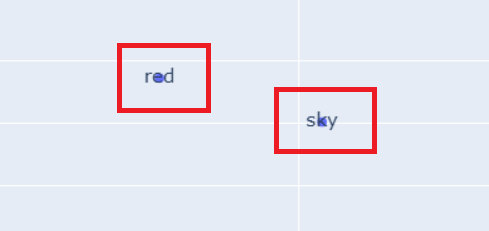

Por el disco y la canción "Under the Red Sky", que lo repite en el estribillo.

<br />

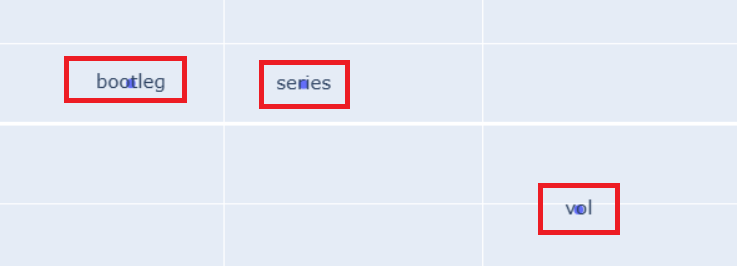

Por los discos "The Bootleg Series Volumes ...".

<br />

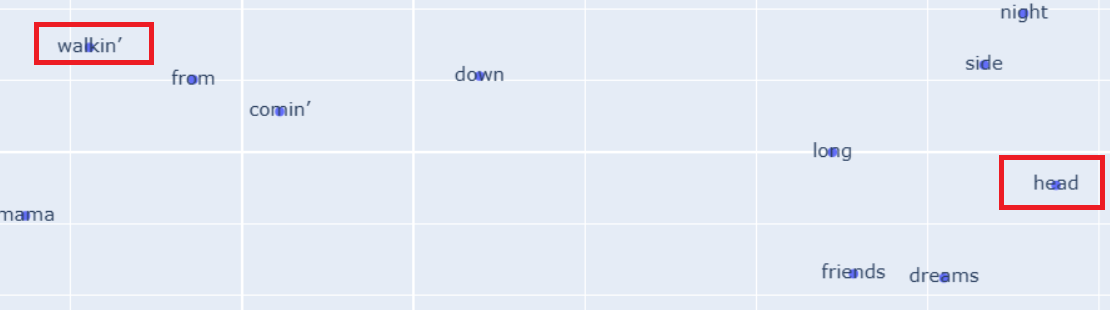

Por la canción "Love Sick", que repite en el estribillo "Walkin' with you in my head".

<br />

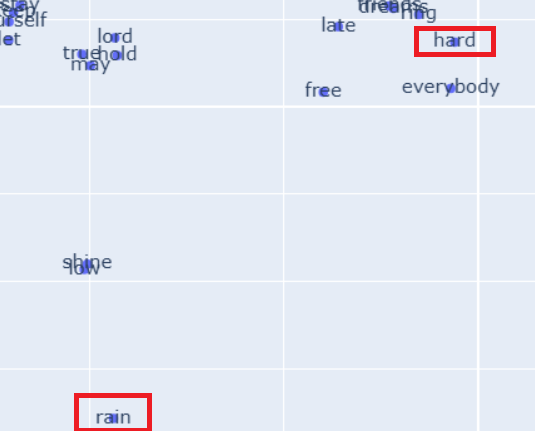

Por la canción "A Hard Rain's A-Gonna Fall", que lo repite en el estribillo.

<br />

---